In [1]:
import requests
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from scipy.special import softmax
import numpy as np

/home/maximilian.laechelin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")


api_key = 'api key'

/home/maximilian.laechelin/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
# get channel id
def get_channel_id(api_key, handle):
    search_url = 'https://www.googleapis.com/youtube/v3/search'
    search_params = {
        'part': 'snippet',
        'q': handle,  
        'type': 'channel',
        'key': api_key
    }
    search_response = requests.get(search_url, params=search_params)
    search_data = search_response.json()
    if search_data['items']:
        return search_data['items'][0]['id']['channelId']
    return None

# get uploads playlist ID
def get_uploads_playlist_id(api_key, channel_id):
    channel_url = f'https://www.googleapis.com/youtube/v3/channels'
    channel_params = {
        'part': 'contentDetails',
        'id': channel_id,
        'key': api_key
    }
    channel_response = requests.get(channel_url, params=channel_params)
    channel_data = channel_response.json()
    return channel_data['items'][0]['contentDetails']['relatedPlaylists']['uploads']

# get all video IDs from the uploads playlist
def get_video_ids(api_key, uploads_playlist_id):
    video_ids = []
    next_page_token = None
    while True:
        playlist_items_url = 'https://www.googleapis.com/youtube/v3/playlistItems'
        playlist_params = {
            'part': 'snippet',
            'playlistId': uploads_playlist_id,
            'maxResults': 100,
            'key': api_key,
            'pageToken': next_page_token  
        }
        videos_response = requests.get(playlist_items_url, params=playlist_params)
        videos_data = videos_response.json()
        video_ids += [item['snippet']['resourceId']['videoId'] for item in videos_data['items']]
        next_page_token = videos_data.get('nextPageToken')
        if not next_page_token:
            break
    return video_ids

# get video upload date
def get_video_details(api_key, video_id):
    video_details_url = 'https://www.googleapis.com/youtube/v3/videos'
    video_params = {
        'part': 'snippet',
        'id': video_id,
        'key': api_key
    }
    video_response = requests.get(video_details_url, params=video_params)
    video_data = video_response.json()
    return video_data['items'][0]['snippet']['publishedAt']  # Return upload date

# get comments from a video
def get_video_comments(api_key, video_id):
    comments_url = 'https://www.googleapis.com/youtube/v3/commentThreads'
    comments_params = {
        'part': 'snippet',
        'videoId': video_id,
        'key': api_key,
        'maxResults': 200  
    }
    comments_response = requests.get(comments_url, params=comments_params)
    comments_data = comments_response.json()
    return comments_data.get('items', [])

# calculate sentiment with BERTweet
def calculate_bertweet_sentiment(comment_text):
    inputs = tokenizer(comment_text, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    scores = outputs[0][0].detach().numpy()
    scores = softmax(scores)  # Apply softmax to get probabilities
    # return sentiment classification (Neutral, Positive, Negative)
    neutral = scores[1]
    positive = scores[2]
    negative = scores[0]
    
    sentiment_class = 'neutral' if neutral > 0.5 else 'positive' if positive > 0.5 else 'negative'
    sentiment_score = scores[2] - scores[0]  # Positive - Negative (like a compound score)
    
    return sentiment_class, sentiment_score

# analyze comments and return neutral/negative counts and sentiment scores
def analyze_comments(video_ids, api_key):
    comment_results = []
    for video_id in video_ids:
        upload_date = get_video_details(api_key, video_id)
        comments = get_video_comments(api_key, video_id)
        
        for comment in comments:
            comment_text = comment['snippet']['topLevelComment']['snippet']['textDisplay']
            comment_date = comment['snippet']['topLevelComment']['snippet']['publishedAt']

            # calculate sentiment using BERTweet
            sentiment_class, bertweet_sentiment_score = calculate_bertweet_sentiment(comment_text)

            comment_results.append({
                'video_id': video_id,
                'comment_date': comment_date,
                'upload_date': upload_date,
                'comment_text': comment_text,
                'bertweet_sentiment_class': sentiment_class,
                'bertweet_sentiment_score': bertweet_sentiment_score
            })
    return pd.DataFrame(comment_results)

# plot total neutral/negative counts per month
def plot_neutral_negative_counts(df, events):
    df['comment_date'] = pd.to_datetime(df['comment_date'])
    
    # count neutral and negative comments by month
    neutral_counts = df[df['bertweet_sentiment_class'] == 'neutral'].set_index('comment_date').resample('M').size()
    negative_counts = df[df['bertweet_sentiment_class'] == 'negative'].set_index('comment_date').resample('M').size()

    # Ppot neutral and negative counts
    plt.figure(figsize=(12, 6))
    plt.plot(neutral_counts.index, neutral_counts, label='Neutral Comments', marker='o', color='blue')
    plt.plot(negative_counts.index, negative_counts, label='Negative Comments', marker='x', color='red')

    # add vertical lines for events
    for event_date, event_label in events.items():
        plt.axvline(x=event_date, color='gray', linestyle='--', lw=2)
        plt.text(event_date + pd.Timedelta(days=10), plt.ylim()[1] * 0.9, event_label, rotation=90, verticalalignment='top', horizontalalignment='left')

    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.title('Monthly Neutral and Negative Comment Counts')
    plt.legend()
    plt.tight_layout()
    plt.show()

# plot average sentiment score per month (BERTweet)
def plot_average_sentiment(df, events):
    df['comment_date'] = pd.to_datetime(df['comment_date'])
    
    # aggregate average sentiment score per month
    monthly_bertweet_sentiment = df.set_index('comment_date').resample('M')['bertweet_sentiment_score'].mean().reset_index()

    # plot average sentiment score
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_bertweet_sentiment['comment_date'], monthly_bertweet_sentiment['bertweet_sentiment_score'], label='Average BERTweet Sentiment', marker='o', color='green')

    for event_date, event_label in events.items():
        plt.axvline(x=event_date, color='gray', linestyle='--', lw=2)
        plt.text(event_date + pd.Timedelta(days=10), plt.ylim()[1] * 0.9, event_label, rotation=90, verticalalignment='top', horizontalalignment='left')

    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.title('Monthly Average Sentiment Score (BERTweet)')
    plt.tight_layout()
    plt.show()


def save_dataframe(df, filename):
    df.to_pickle(f"{filename}.pkl")
    print(f"Dataframe saved as {filename}.pkl")

# Audi

/tmp/ipykernel_819593/770053225.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  neutral_counts = df[df['bertweet_sentiment_class'] == 'neutral'].set_index('comment_date').resample('M').size()
/tmp/ipykernel_819593/770053225.py:120: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  negative_counts = df[df['bertweet_sentiment_class'] == 'negative'].set_index('comment_date').resample('M').size()


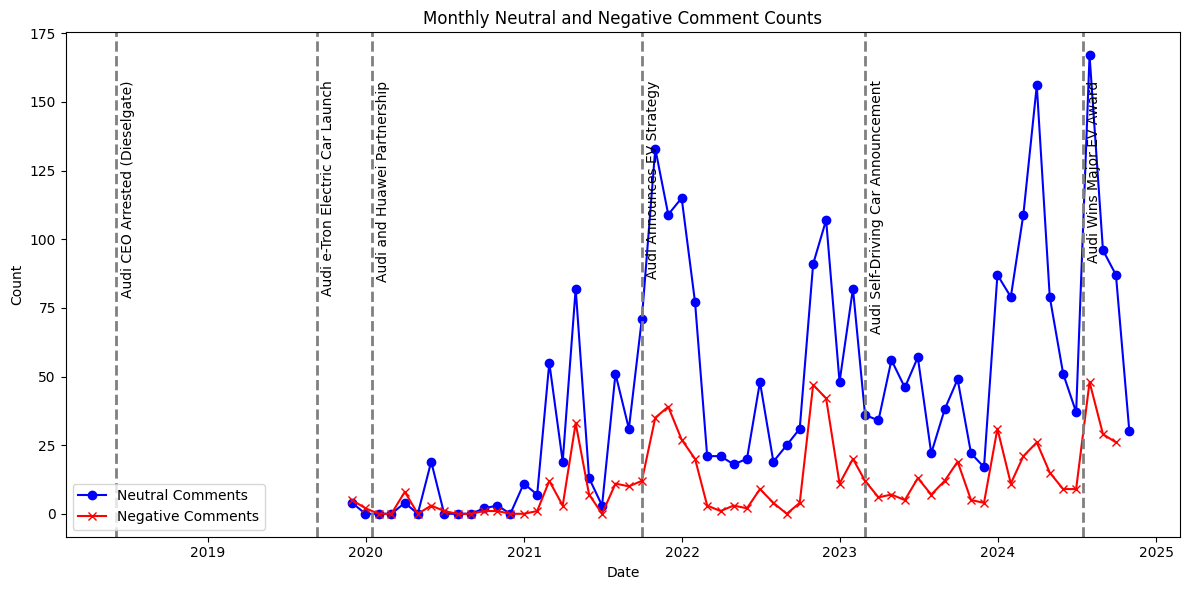

/tmp/ipykernel_819593/770053225.py:144: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_bertweet_sentiment = df.set_index('comment_date').resample('M')['bertweet_sentiment_score'].mean().reset_index()


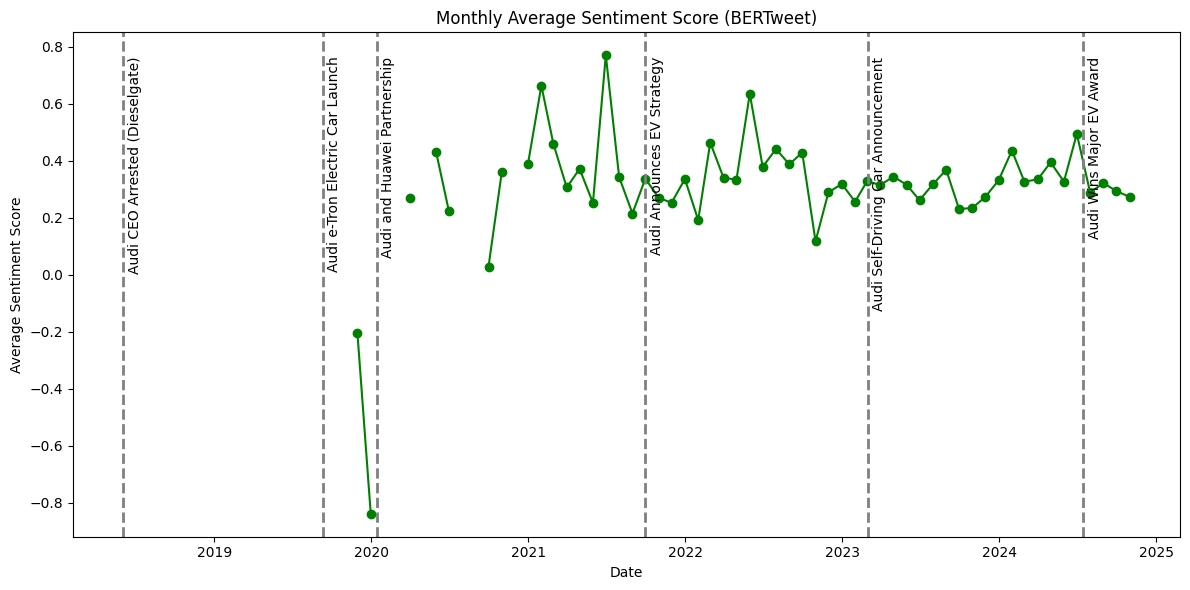

In [4]:
# main execution
handles = ['@Audi']
all_comments_df_audi = pd.DataFrame()

for handle in handles:
    channel_id = get_channel_id(api_key, handle)
    if not channel_id:
        print(f"Channel not found for handle {handle}")
        continue
    
    uploads_playlist_id = get_uploads_playlist_id(api_key, channel_id)
    video_ids = get_video_ids(api_key, uploads_playlist_id)
    comments_df_audi = analyze_comments(video_ids, api_key)
    all_comments_df_audi = pd.concat([all_comments_df_audi, comments_df_audi], ignore_index=True)


events = {
    '2018-06-03': 'Audi CEO Arrested (Dieselgate)',
    '2019-09-10': 'Audi e-Tron Electric Car Launch',
    '2020-01-15': 'Audi and Huawei Partnership',
    '2021-09-30': 'Audi Announces EV Strategy',
    '2023-03-01': 'Audi Self-Driving Car Announcement',
    '2024-07-15': 'Audi Wins Major EV Award'
}
events = {pd.to_datetime(date): event for date, event in events.items()}

plot_neutral_negative_counts(all_comments_df_audi, events)

plot_average_sentiment(all_comments_df_audi, events)

In [5]:
save_dataframe(all_comments_df_audi, "audi_analyzed")

Dataframe saved as audi_analyzed.pkl


In [6]:
all_comments_df_audi

,video_id,comment_date,upload_date,comment_text,bertweet_sentiment_class,bertweet_sentiment_score
0,t5zlByVZrHY,2024-10-10 07:04:10+00:00,2024-10-04T10:38:16Z,Hey Audi do you want model TTTT?,neutral,0.119325
1,t5zlByVZrHY,2024-10-08 12:17:02+00:00,2024-10-04T10:38:16Z,one keylow off mints plz,neutral,0.032428
2,t5zlByVZrHY,2024-10-08 12:16:30+00:00,2024-10-04T10:38:16Z,4 orange,neutral,0.046716
3,t5zlByVZrHY,2024-10-05 02:22:03+00:00,2024-10-04T10:38:16Z,Hope that efoil comes with my SQ6,positive,0.746756
4,t5zlByVZrHY,2024-10-04 23:43:41+00:00,2024-10-04T10:38:16Z,Audi,neutral,0.253115
...,...,...,...,...,...,...
5955,2PYVZsBC4YU,2019-11-20 08:00:44+00:00,2019-11-20T02:42:00Z,"wow, when it comes to unveiling the car. Audi ...",positive,0.990064
5956,2PYVZsBC4YU,2019-11-20 07:22:55+00:00,2019-11-20T02:42:00Z,Обожаю ауди,neutral,-0.049136
5957,2PYVZsBC4YU,2019-11-20 04:38:05+00:00,2019-11-20T02:42:00Z,The front design is pedestrian looking and I f...,negative,-0.928513
5958,2PYVZsBC4YU,2019-11-20 03:13:19+00:00,2019-11-20T02:42:00Z,Should have just built the concept Sportback w...,negative,-0.924366


# Volkswagen

/tmp/ipykernel_819593/770053225.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  neutral_counts = df[df['bertweet_sentiment_class'] == 'neutral'].set_index('comment_date').resample('M').size()
/tmp/ipykernel_819593/770053225.py:120: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  negative_counts = df[df['bertweet_sentiment_class'] == 'negative'].set_index('comment_date').resample('M').size()


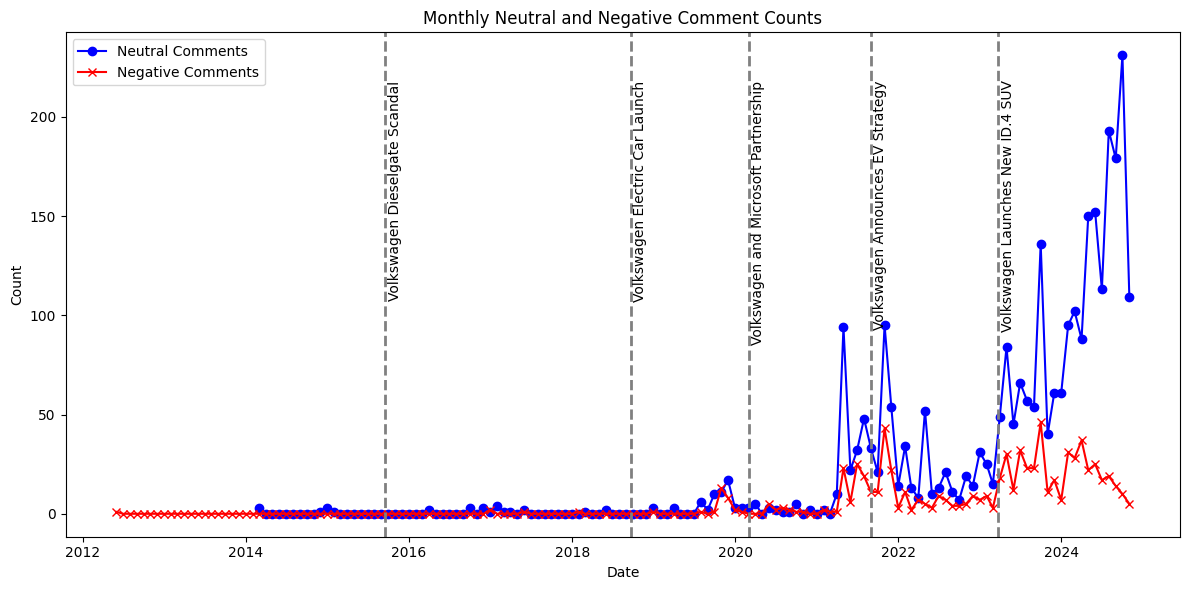

/tmp/ipykernel_819593/770053225.py:144: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_bertweet_sentiment = df.set_index('comment_date').resample('M')['bertweet_sentiment_score'].mean().reset_index()


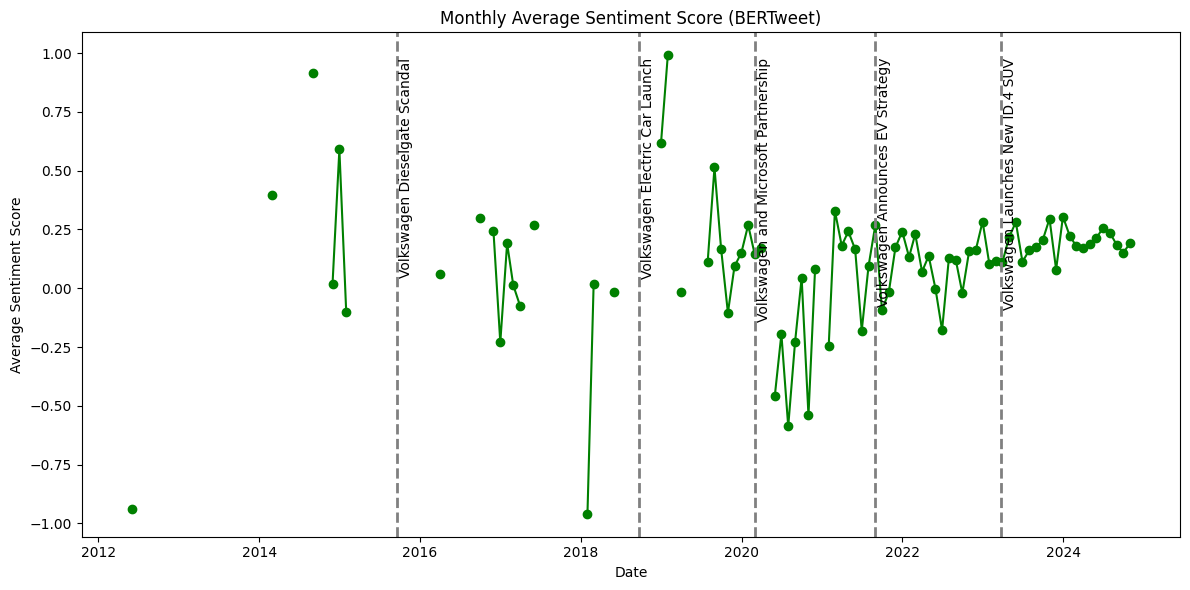

In [7]:
handles = ['@volkswagen', '@volkswagen_usa']
all_comments_df_volkswagen = pd.DataFrame()

for handle in handles:
    channel_id = get_channel_id(api_key, handle)
    if not channel_id:
        print(f"Channel not found for handle {handle}")
        continue
    
    uploads_playlist_id = get_uploads_playlist_id(api_key, channel_id)
    video_ids = get_video_ids(api_key, uploads_playlist_id)
    comments_df_volkswagen = analyze_comments(video_ids, api_key)
    all_comments_df_volkswagen = pd.concat([all_comments_df_volkswagen, comments_df_volkswagen], ignore_index=True)


events = {
    '2015-09-18': 'Volkswagen Dieselgate Scandal',
    '2018-09-20': 'Volkswagen Electric Car Launch',
    '2020-03-02': 'Volkswagen and Microsoft Partnership',
    '2021-08-30': 'Volkswagen Announces EV Strategy',
    '2023-03-25': 'Volkswagen Launches New ID.4 SUV',
}
events = {pd.to_datetime(date): event for date, event in events.items()}

plot_neutral_negative_counts(all_comments_df_volkswagen, events)


plot_average_sentiment(all_comments_df_volkswagen, events)

In [8]:
save_dataframe(all_comments_df_volkswagen, "volkswagen_analyzed")

Dataframe saved as volkswagen_analyzed.pkl


# BMW

/tmp/ipykernel_819593/770053225.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  neutral_counts = df[df['bertweet_sentiment_class'] == 'neutral'].set_index('comment_date').resample('M').size()
/tmp/ipykernel_819593/770053225.py:120: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  negative_counts = df[df['bertweet_sentiment_class'] == 'negative'].set_index('comment_date').resample('M').size()


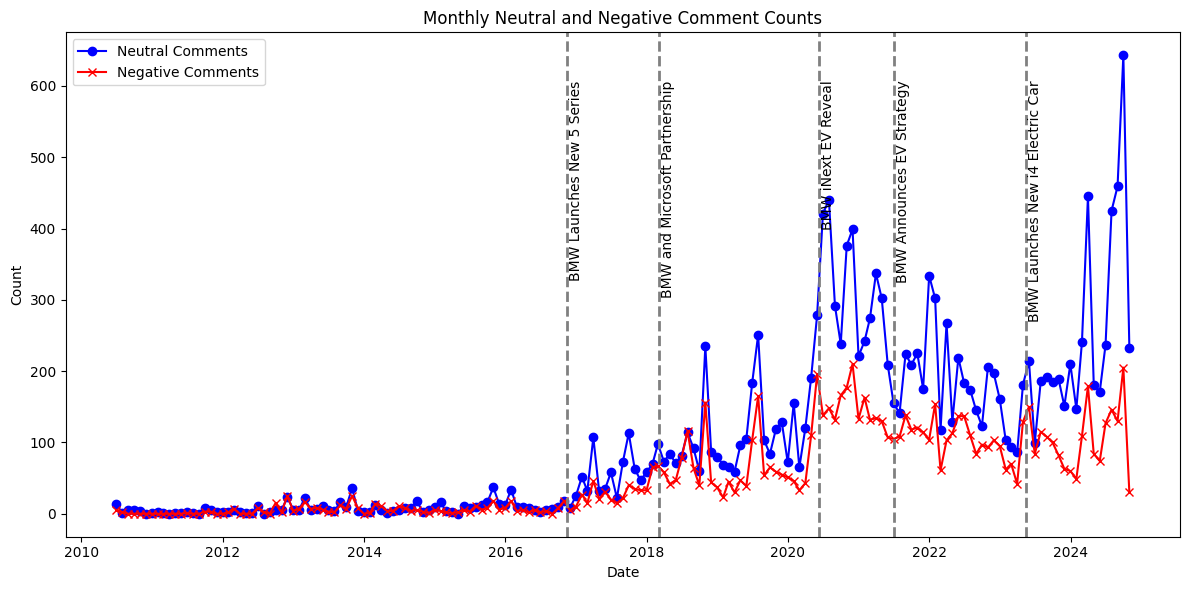

/tmp/ipykernel_819593/770053225.py:144: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_bertweet_sentiment = df.set_index('comment_date').resample('M')['bertweet_sentiment_score'].mean().reset_index()


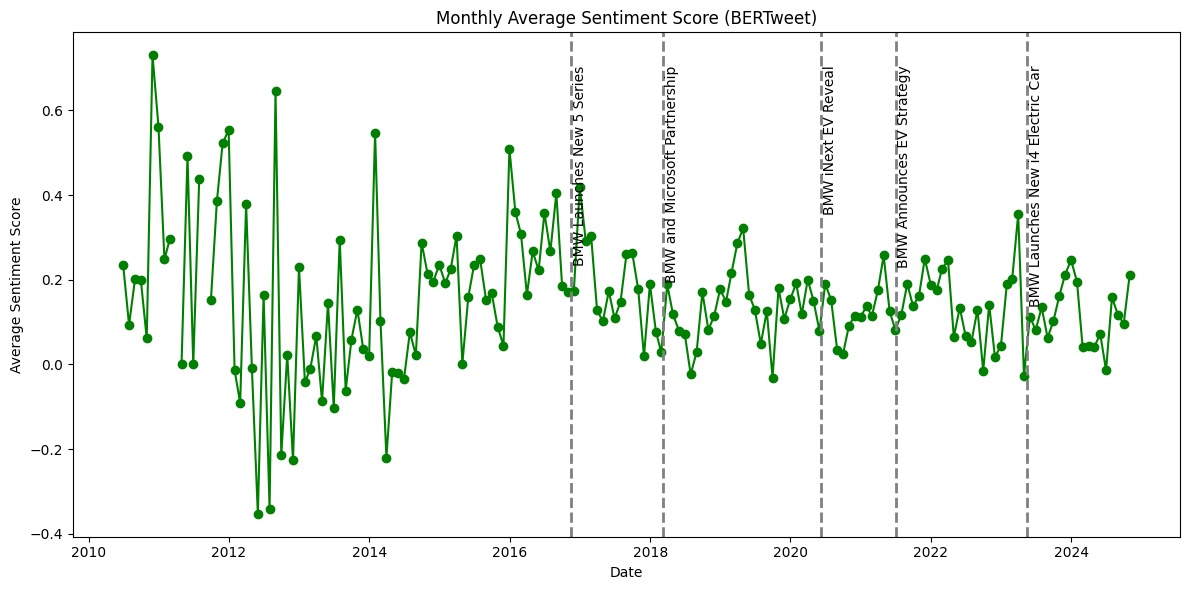

In [12]:
handles = ['@bmw']
all_comments_df_bmw = pd.DataFrame()

for handle in handles:
    channel_id = get_channel_id(api_key, handle)
    if not channel_id:
        print(f"Channel not found for handle {handle}")
        continue
    
    uploads_playlist_id = get_uploads_playlist_id(api_key, channel_id)
    video_ids = get_video_ids(api_key, uploads_playlist_id)
    comments_df_bmw = analyze_comments(video_ids, api_key)
    all_comments_df_bmw = pd.concat([all_comments_df_bmw, comments_df_bmw], ignore_index=True)

events = {
    '2016-11-15': 'BMW Launches New 5 Series',
    '2018-03-07': 'BMW and Microsoft Partnership',
    '2020-06-10': 'BMW iNext EV Reveal',
    '2021-07-01': 'BMW Announces EV Strategy',
    '2023-05-15': 'BMW Launches New i4 Electric Car',
}
events = {pd.to_datetime(date): event for date, event in events.items()}

plot_neutral_negative_counts(all_comments_df_bmw, events)

plot_average_sentiment(all_comments_df_bmw, events)


In [13]:
save_dataframe(all_comments_df_bmw, "bmw_analyzed")

Dataframe saved as bmw_analyzed.pkl


# Porsche

/tmp/ipykernel_819593/770053225.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  neutral_counts = df[df['bertweet_sentiment_class'] == 'neutral'].set_index('comment_date').resample('M').size()
/tmp/ipykernel_819593/770053225.py:120: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  negative_counts = df[df['bertweet_sentiment_class'] == 'negative'].set_index('comment_date').resample('M').size()


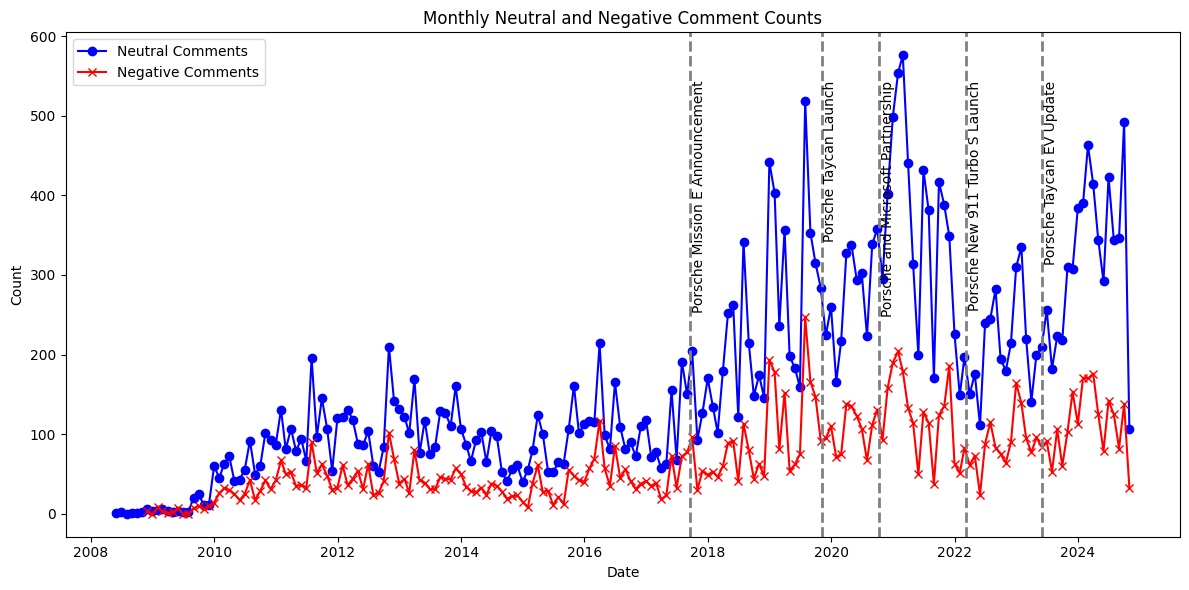

/tmp/ipykernel_819593/770053225.py:144: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_bertweet_sentiment = df.set_index('comment_date').resample('M')['bertweet_sentiment_score'].mean().reset_index()


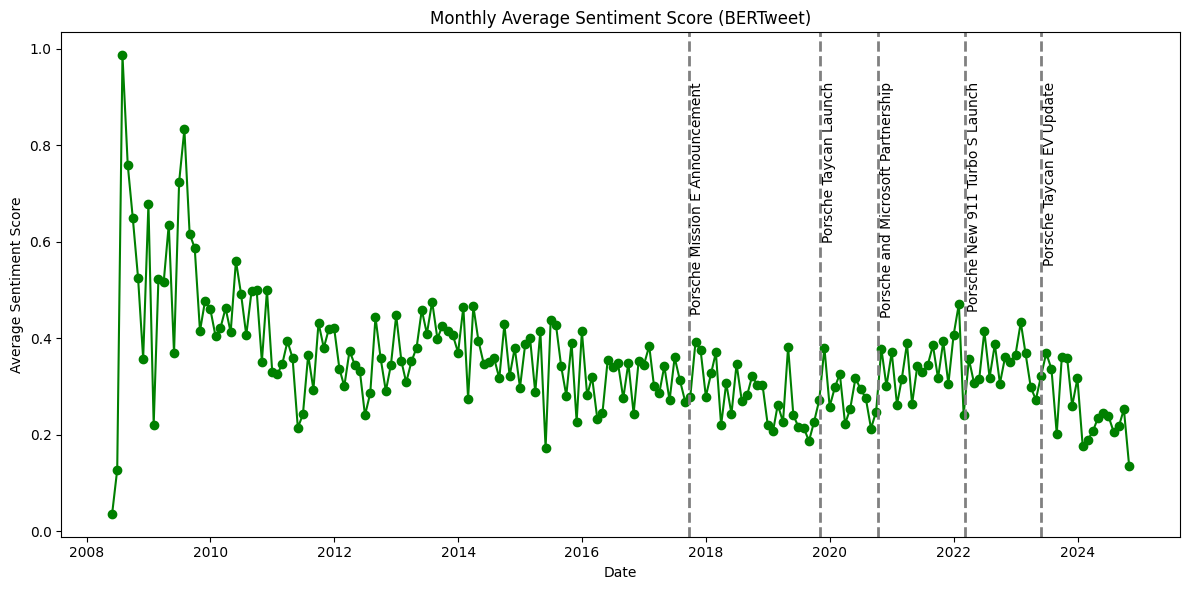

In [14]:
handles = ['@Porsche']
all_comments_df_porsche = pd.DataFrame()

for handle in handles:
    channel_id = get_channel_id(api_key, handle)
    if not channel_id:
        print(f"Channel not found for handle {handle}")
        continue
    
    uploads_playlist_id = get_uploads_playlist_id(api_key, channel_id)
    video_ids = get_video_ids(api_key, uploads_playlist_id)
    comments_df_porsche = analyze_comments(video_ids, api_key)
    all_comments_df_porsche = pd.concat([all_comments_df_porsche, comments_df_porsche], ignore_index=True)

events = {
    '2017-09-20': 'Porsche Mission E Announcement',
    '2019-11-05': 'Porsche Taycan Launch',
    '2020-10-12': 'Porsche and Microsoft Partnership',
    '2022-03-10': 'Porsche New 911 Turbo S Launch',
    '2023-06-01': 'Porsche Taycan EV Update',
}
events = {pd.to_datetime(date): event for date, event in events.items()}

plot_neutral_negative_counts(all_comments_df_porsche, events)

plot_average_sentiment(all_comments_df_porsche, events)


In [20]:
save_dataframe(all_comments_df_porsche, "porsche_analyzed")

Dataframe saved as porsche_analyzed.pkl


# Similarity Search